In [1]:
import numpy as np
from pointcloud_helpers import *

import keras
from keras.losses import MSE
from keras.layers import Lambda, Input, Dense, Conv1D, Conv2D, MaxPooling1D, BatchNormalization, MaxPooling2D, Flatten, Reshape, UpSampling2D, Dropout
from keras.models import Model, Sequential,load_model
from keras import callbacks
from keras import backend as K
import pandas as pd
config = K.tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

K.clear_session()

Done compiling CUDA scripts


Using TensorFlow backend.


In [2]:
semantic_net = load_model("../data/chair_net_150.h5", custom_objects={ 'emd': emd})
chair_ptclouds_ids = np.load("../data/chair_ptclouds_ids.npz", allow_pickle=True)["arr_0"]

In [6]:
import pickle

with open("chair_ptclouds_ids.pkl", "wb") as f:
    pickle.dump(chair_ptclouds_ids, f)

In [14]:
decoder = semantic_net.layers[-1].layers[-1]
encoder = semantic_net.layers[-1].layers[-2]

In [15]:
import time
import numpy as np
import torch
from torch import nn
from torch.autograd import Function

import pickle

from torch import optim
import gc
import torchvision
from torch.autograd import Variable
import pickle
import numpy as np
import random
random.seed(1)


In [245]:
class Encoder(nn.Module):
    #Takes in n x c x features
    def __init__(self, ptcloud_size, hidden_dim):
        
        self.ptcloud_size = ptcloud_size
        self.hidden_dim = hidden_dim
        
        super(Encoder, self).__init__()
        self.conv1  = torch.nn.Conv2d(3,64,1)
        self.relu1 = torch.nn.ReLU()
        self.bnorm1 = torch.nn.BatchNorm2d(64)
        self.conv2 = torch.nn.Conv2d(64,128,1)
        self.relu2 = torch.nn.ReLU()
        self.bnorm2 = torch.nn.BatchNorm2d(128)
        self.conv3 = torch.nn.Conv2d(128, 128,1)
        self.relu3 = torch.nn.ReLU()
        self.bnorm3 = torch.nn.BatchNorm2d(128)
        self.conv4 = torch.nn.Conv2d(128, 256, 1)
        self.relu4 = torch.nn.ReLU()
        self.bnorm4 = torch.nn.BatchNorm2d(256)
        self.conv5 = torch.nn.Conv2d(256, 128, 1)
        self.relu5 = torch.nn.ReLU()
        self.bnorm5 = torch.nn.BatchNorm2d(128)
        self.maxpool = torch.nn.MaxPool2d(kernel_size=(2048,1))

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.bnorm1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.bnorm2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.bnorm3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.bnorm4(x)
        x = self.conv5(x)
        x = self.relu5(x)
        x = self.bnorm5(x)
        x = self.maxpool(x)
        return x



class Decoder(nn.Module):
    
    def __init__(self, ptcloud_size, hidden_dim):
        super(Decoder, self).__init__()
        
        self.ptcloud_size = ptcloud_size
        self.hidden_dim = hidden_dim

        self.conv1= torch.nn.Conv2d(in_channels=self.hidden_dim, out_channels=1024, kernel_size=1)
        self.relu1 = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=1)
        self.relu2 = torch.nn.ReLU()
        self.flatten1 = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(in_features=2048, out_features=6144)
        self.relu3 = torch.nn.ReLU()
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten1(x)
        x = self.linear1(x)
        x = self.relu3(x)
        return x


In [246]:
class Shape_Autoencoder(nn.Module):
    def __init__(self):
        super(Shape_Autoencoder, self).__init__()
        
        self.encoder = Encoder(2048,128).float()
        self.decoder = Decoder(2048,128).float()
     

    def forward(self,ptcloud):

        encoded=  self.encoder.forward(ptcloud)

        return self.decoder.forward(encoded).view(self.batch_size, 2048,3)
   


In [247]:
import torch
py_encoder = Encoder(2048,128).float()

In [248]:
py_decoder = Decoder(2048,128).float()

In [433]:
py_encoder.bnorm1.weight.data

tensor([0.9939, 0.9968, 1.0011, 0.9964, 1.0012, 1.0023, 0.9973, 1.0005, 0.9958,
        0.9974, 1.0012, 1.0013, 1.0001, 0.9988, 1.0055, 0.9951, 1.0013, 0.9997,
        0.9956, 1.0001, 1.0029, 0.9945, 1.0048, 1.0023, 0.9989, 1.0009, 1.0006,
        1.0019, 0.9905, 0.9974, 0.9983, 0.9998, 1.0055, 1.0014, 1.0013, 1.0045,
        1.0008, 0.9998, 0.9978, 1.0072, 1.0025, 0.9969, 1.0007, 1.0048, 1.0015,
        1.0042, 0.9982, 0.9913, 0.9962, 0.9937, 0.9990, 1.0007, 1.0047, 1.0047,
        1.0014, 0.9913, 1.0043, 0.9983, 1.0041, 1.0003, 1.0022, 1.0048, 0.9967,
        0.9944])

In [434]:
encoder.layers[2].get_weights()[0].T

array([0.99394804, 0.9967955 , 1.0010917 , 0.9963683 , 1.0011727 ,
       1.0022664 , 0.9973492 , 1.0005453 , 0.99584347, 0.9973929 ,
       1.0012386 , 1.0012639 , 1.0000945 , 0.9988478 , 1.0054606 ,
       0.9951188 , 1.0013121 , 0.9997094 , 0.99562496, 1.000142  ,
       1.0029316 , 0.9945102 , 1.004774  , 1.0023054 , 0.9988519 ,
       1.0008761 , 1.0006262 , 1.0018909 , 0.9904766 , 0.9974483 ,
       0.9982689 , 0.9997863 , 1.0055174 , 1.001362  , 1.0013484 ,
       1.0044749 , 1.0008162 , 0.99975944, 0.9978018 , 1.0071807 ,
       1.0025197 , 0.99685663, 1.0007247 , 1.0047512 , 1.0015328 ,
       1.0042374 , 0.99823695, 0.9913109 , 0.99616146, 0.99371356,
       0.9989998 , 1.0007083 , 1.0046558 , 1.004737  , 1.0014322 ,
       0.9913376 , 1.0043366 , 0.9982779 , 1.0041332 , 1.0003216 ,
       1.0021611 , 1.0047557 , 0.99667937, 0.9944299 ], dtype=float32)

In [387]:


py_encoder.conv1.weight.data = torch.tensor(encoder.layers[1].get_weights()[0].T)
py_encoder.conv1.bias.data = torch.tensor(encoder.layers[1].get_weights()[1])

py_encoder.bnorm1.weight.data = torch.tensor(encoder.layers[2].get_weights()[0].T)
py_encoder.bnorm1.bias.data = torch.tensor(encoder.layers[2].get_weights()[1])


py_encoder.conv2.weight.data = torch.tensor(encoder.layers[3].get_weights()[0].T)
py_encoder.conv2.bias.data = torch.tensor(encoder.layers[3].get_weights()[1])


py_encoder.bnorm2.weight.data = torch.tensor(encoder.layers[4].get_weights()[0].T)
py_encoder.bnorm2.bias.data = torch.tensor(encoder.layers[4].get_weights()[1])


py_encoder.conv3.weight.data = torch.tensor(encoder.layers[5].get_weights()[0].T)
py_encoder.conv3.bias.data = torch.tensor(encoder.layers[5].get_weights()[1])


py_encoder.bnorm3.weight.data = torch.tensor(encoder.layers[6].get_weights()[0].T)
py_encoder.bnorm3.bias.data = torch.tensor(encoder.layers[6].get_weights()[1])


py_encoder.conv4.weight.data = torch.tensor(encoder.layers[7].get_weights()[0].T)
py_encoder.conv4.bias.data = torch.tensor(encoder.layers[7].get_weights()[1])


py_encoder.bnorm4.weight.data = torch.tensor(encoder.layers[8].get_weights()[0].T)
py_encoder.bnorm4.bias.data = torch.tensor(encoder.layers[8].get_weights()[1])


py_encoder.conv5.weight.data = torch.tensor(encoder.layers[9].get_weights()[0].T)
py_encoder.conv5.bias.data = torch.tensor(encoder.layers[9].get_weights()[1])


py_encoder.bnorm5.weight.data = torch.tensor(encoder.layers[10].get_weights()[0].T)
py_encoder.bnorm5.bias.data = torch.tensor(encoder.layers[10].get_weights()[1])


py_decoder.conv1.weight.data = torch.tensor(decoder.layers[1].get_weights()[0].T)
py_decoder.conv1.bias.data = torch.tensor(decoder.layers[1].get_weights()[1])

py_decoder.conv2.weight.data = torch.tensor(decoder.layers[2].get_weights()[0].T)
py_decoder.conv2.bias.data = torch.tensor(decoder.layers[2].get_weights()[1])

py_decoder.linear1.weight.data = torch.tensor(decoder.layers[3].get_weights()[0].T)
py_decoder.linear1.bias.data = torch.tensor(decoder.layers[3].get_weights()[1])



In [388]:
encoder.layers[11].weights

[]

In [389]:
x = chair_ptclouds_ids[0][0].reshape(1,3,2048,1)
x = Variable(torch.tensor(x))



In [404]:
correct_encoding = encoder.predict(chair_ptclouds_ids[0][0].reshape(1,2048,1,3))

In [413]:
correct_encoding_tensor = torch.tensor(correct_encoding.reshape((1,128,1,1)))

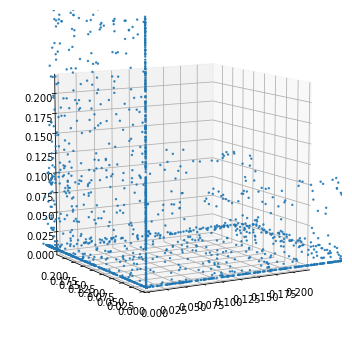

In [419]:
plot_ptcloud(py_decoder.forward(correct_encoding_tensor).detach().numpy().reshape(2048,3))

AttributeError: 'Decoder' object has no attribute 'weights'

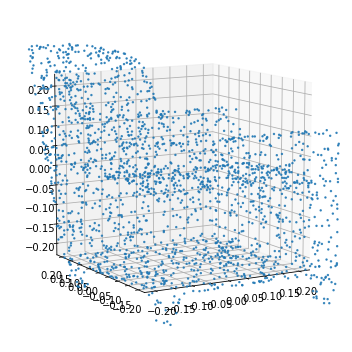

In [402]:
plot_ptcloud(chair_ptclouds_ids[0][0])

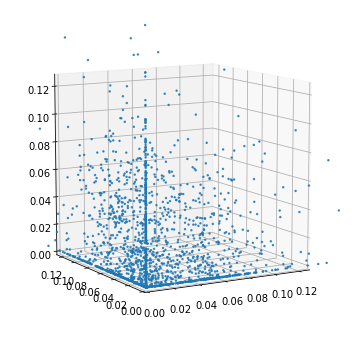

In [403]:
plot_ptcloud(py_decoder.forward(py_encoder.forward(x)).detach().numpy().reshape(2048,3))

In [277]:
encoder.layers[1].

In [273]:
x = py_encoder.conv1(x)
x = py_encoder.relu1(x)
x = py_encoder.bnorm1(x)
x = py_encoder.conv2(x)
x = py_encoder.relu2(x)
x = py_encoder.bnorm2(x)
x = py_encoder.conv3(x)
x = py_encoder.relu3(x)
x = py_encoder.bnorm3(x)
x = py_encoder.conv4(x)
x = py_encoder.relu4(x)
x = py_encoder.bnorm4(x)
x = py_encoder.conv5(x)
x = py_encoder.relu5(x)
x = py_encoder.bnorm5(x)
x = py_encoder.maxpool(x)

RuntimeError: The size of tensor a (3) must match the size of tensor b (128) at non-singleton dimension 1

In [203]:
x = py_decoder.conv1(x)

In [204]:

x = py_decoder.conv2(x)


In [209]:
x = py_decoder.flatten1(x)

In [210]:
x = py_decoder.linear1(x)

In [287]:
encoder.layers[3].get_weights()[1].shape

(128,)

In [315]:
x = chair_ptclouds_ids[0][0].reshape(1,3,2048,1)
x = Variable(torch.tensor(x))



In [300]:
conv1 = torch.tensor(encoder.layers[1].get_weights()[0].T) * x
bnorm1 = torch.tensor(encoder.layers[2].get_weights()[0].T) * conv1
conv2 = torch.tensor(encoder.layers[3].get_weights()[0].T) * bnorm1 
bnorm2 = torch.tensor(encoder.layers[4].get_weights()[0].T) * conv2
conv3 = torch.tensor(encoder.layers[5].get_weights()[0].T) * bnorm2
bnorm3 = torch.tensor(encoder.layers[6].get_weights()[0].T) * conv3
conv4 = torch.tensor(encoder.layers[7].get_weights()[0].T) * bnorm3

RuntimeError: The size of tensor a (64) must match the size of tensor b (3) at non-singleton dimension 1

In [313]:
py_conv1 = py_encoder.conv1.weight.data * x
py_bnorm1 = py_encoder.bnorm1.weight.data * py_conv1
py_conv2 = py_encoder.conv2.weight.data * py_bnorm1

RuntimeError: The size of tensor a (64) must match the size of tensor b (3) at non-singleton dimension 1

In [309]:
conv1.shape

torch.Size([64, 3, 2048, 1])

In [310]:
bnorm1.shape

torch.Size([64, 3, 2048, 64])

In [311]:
py_conv1.shape

torch.Size([64, 3, 2048, 1])

In [330]:
en_weights=encoder.get_weights()
de_weights=decoder.get_weights()

In [370]:
for layer in encoder.layers:
    
    layer_weights = layer.get_weights()
    if len(layer_weights) > 0:
        print(layer.name)
        print(layer_weights[0].shape)
        print(layer_weights[1].shape)


conv2d_1
(1, 1, 3, 64)
(64,)
batch_normalization_1
(64,)
(64,)
conv2d_2
(1, 1, 64, 128)
(128,)
batch_normalization_2
(128,)
(128,)
conv2d_3
(1, 1, 128, 128)
(128,)
batch_normalization_3
(128,)
(128,)
conv2d_4
(1, 1, 128, 256)
(256,)
batch_normalization_4
(256,)
(256,)
conv2d_5
(1, 1, 256, 128)
(128,)
batch_normalization_5
(128,)
(128,)


In [359]:
encoder.layers

In [ ]:
first_layer_weights = encoder.layers[1].get_weights()[0]
first_layer_biases  = encoder.layers[1].get_weights()[1]
second_layer_weights = encoder.layers[2].get_weights()[0]
second_layer_biases  = encoder.layers[2].get_weights()[1]

In [339]:
py_encoder.conv1.weight.data = torch.from_numpy(np.transpose(weights[0]))
py_encoder.conv1.bias.data=torch.from_numpy(weights[1])
py_encoder.bnorm1.weight.data=torch.from_numpy(np.transpose(weights[2]))
py_encoder.bnorm1.bias.data=torch.from_numpy(weights[3])
py_encoder.conv2.weight.data=torch.from_numpy(np.transpose(weights[4]))
py_encoder.conv2.bias.data=torch.from_numpy(weights[5])

In [340]:


py_encoder.bnorm2.weight.data=torch.from_numpy(np.transpose(weights[6]))
py_encoder.bnorm2.bias.data=torch.from_numpy(weights[7])
py_encoder.conv3.weight.data=torch.from_numpy(np.transpose(weights[8]))
py_encoder.conv3.bias.data=torch.from_numpy(weights[9])




In [ ]:
py_encoder.bnorm3.weight.data=torch.from_numpy(np.transpose(weights[10]))
py_encoder.bnorm3.bias.data=torch.from_numpy(weights[11])

py_encoder.conv4.weight.data=torch.from_numpy(np.transpose(weights[12]))
py_encoder.conv4.bias.data=torch.from_numpy(weights[13])

py_encoder.bnorm4.weight.data=torch.from_numpy(np.transpose(weights[14]))
py_encoder.bnorm4.bias.data=torch.from_numpy(weights[15])

py_encoder.conv5.weight.data=torch.from_numpy(np.transpose(weights[16]))
py_encoder.conv5.bias.data=torch.from_numpy(weights[17])

py_encoder.bnorm4.weight.data=torch.from_numpy(np.transpose(weights[14]))
py_encoder.bnorm4.bias.data=torch.from_numpy(weights[15])


In [436]:
semantic_net = load_model("../data/chair_net_150.h5")

ValueError: Unknown loss function:emd

In [441]:
import pickle
with open("chair_model_weights.pkl", "wb") as f:
    pickle.dump(semantic_net.get_weights(),f)

In [442]:
import pickle
with open("chair_encoder_weights.pkl", "wb") as f:
    pickle.dump(encoder.get_weights(),f)

In [443]:
import pickle
with open("chair_decoder_weights.pkl", "wb") as f:
    pickle.dump(decoder.get_weights(),f)